In [ ]:
'''
This script is used to init the clustering/class centers and predict pseudo labels&attributes to the target data
'''

In [57]:
import torch.nn.functional as F
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans

## (0) Load data (ResNet features, Labels, Attributes)

In [58]:
att10 = pd.read_csv('./attributes_bi10.csv', header=None,index_col=None) # Attributes of the shared 10 categories
att = pd.read_csv('./attributes_bi.csv', header=None,index_col=None)

In [59]:
att.shape

(17, 85)

In [60]:
subdomain = ['AwA', 'painting', 'real'] #, 'clipart', 'infograph', 'quickdraw', 'sketch']
class_num = 17
src = subdomain[0]
tgt = subdomain[2]
# ImageNet pre-trained ResNet-50 Features
xs = pd.read_csv('./'+src+'10_feats.csv', header=None, index_col=None)
ys = pd.read_csv('./'+src+'10_labels.csv', header=None, index_col=None)
xt = pd.read_csv('./'+tgt+'_feats.csv', header=None, index_col=None)
yt = pd.read_csv('./'+tgt+'_labels.csv', header=None, index_col=None)
print(src, xs.shape, '-->', tgt, xt.shape)

AwA (9343, 2048) --> real (10047, 2048)


In [61]:
Xs = xs.values
Ys = ys[0].values
Xt = xt.values
Yt = yt[0].values

In [62]:
np.unique(Ys)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [63]:
# Get the source domain class prototypes by groundtruth
Prot_Xs = np.zeros((10, 2048))
n_s = np.zeros(10)
for i in range(len(Xs)):
    xi = Xs[i,:]
    yi = Ys[i]
    Prot_Xs[yi,:] += xi
    n_s[yi] += 1
Prot_Xs /= n_s.reshape(-1,1)

In [64]:
# Ground-truth class centers of target domain, NOT SAVED, for evaluation
Prot_Xt = np.zeros((17, 2048))
n_t = np.zeros(17)
for i in range(len(Xt)):
    xi = Xt[i,:]
    yi = Yt[i]
    Prot_Xt[yi,:] += xi
    n_t[yi] += 1
Prot_Xt /= n_t.reshape(-1,1)
true_Prot_Xt = Prot_Xt

In [65]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if cuda else "cpu")
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

## 1. Classify Target Samples based on the Source Prototypes/ClassCenters

In [66]:
# Classification based on the distance of same to the class/clustering centers
def classify(z,c,dist='cosine',T=1):
    eps = 1e-5
    if dist == 'cosine':
        norm = torch.mm(torch.norm(z, p=2, dim=1).unsqueeze(1), torch.norm(c, p=2, dim=1).unsqueeze(0))
        sim = torch.mm(z, c.t()) / torch.max(norm, eps * torch.ones_like(norm))
    elif dist == 'euclidean':
        dist_map = torch.cdist(z, c, p=2)
        sim = 1 - dist_map
    else:
        raise ValueError("dist does not exist!")
    prob = F.softmax(sim / T, dim=1)
    y_prob, y_pred = torch.max(prob, dim=1)
    return prob, y_prob, y_pred

In [67]:
cs = torch.Tensor(Prot_Xs).type(FloatTensor)
z =torch.Tensor(Xt).type(FloatTensor)
t_prob, yt_prob, yt_pred = classify(z, cs, dist='cosine', T=1)

In [68]:
yt_prob.mean() # Use the mean of prediction as a threshold to split the prediction of the target data (high/low confidence)

tensor(0.1126, device='cuda:0')

In [69]:
th = yt_prob.mean().item() # 0.11, the threshold influence the seen/unseen split of target data

<BarContainer object of 17 artists>

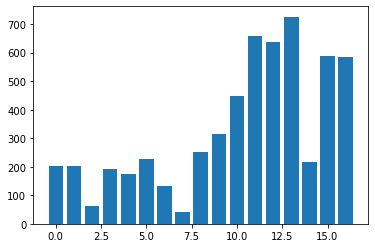

In [70]:
# Viusalize teh distribution of ground-truth categories of samples with low-confidence predictions
low_conf_inds= yt_prob.detach().cpu().numpy() < th
x, h = np.unique(Yt[low_conf_inds], return_counts=True)
plt.bar(x, h)

In [71]:
for i in range(len(x)):
    print("class: ", x[i], " cnt: ", h[i])

class:  0  cnt:  201
class:  1  cnt:  204
class:  2  cnt:  63
class:  3  cnt:  192
class:  4  cnt:  173
class:  5  cnt:  226
class:  6  cnt:  132
class:  7  cnt:  43
class:  8  cnt:  251
class:  9  cnt:  315
class:  10  cnt:  447
class:  11  cnt:  659
class:  12  cnt:  637
class:  13  cnt:  726
class:  14  cnt:  218
class:  15  cnt:  589
class:  16  cnt:  586


In [72]:
h.sum()

5662

<BarContainer object of 17 artists>

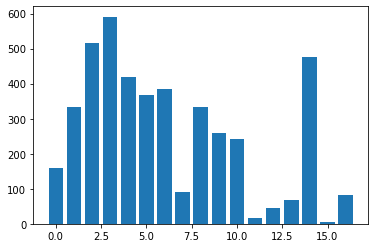

In [73]:
# Viusalize teh distribution of ground-truth categories of samples with high-confidence predictions
high_conf_inds= yt_prob.detach().cpu().numpy() > th
x, h = np.unique(Yt[high_conf_inds], return_counts=True)
plt.bar(x, h)

In [74]:
for i in range(len(x)):
    print("class: ", x[i], " cnt: ", h[i])

class:  0  cnt:  159
class:  1  cnt:  333
class:  2  cnt:  516
class:  3  cnt:  591
class:  4  cnt:  418
class:  5  cnt:  369
class:  6  cnt:  384
class:  7  cnt:  91
class:  8  cnt:  332
class:  9  cnt:  258
class:  10  cnt:  243
class:  11  cnt:  16
class:  12  cnt:  45
class:  13  cnt:  68
class:  14  cnt:  475
class:  15  cnt:  4
class:  16  cnt:  83


<BarContainer object of 10 artists>

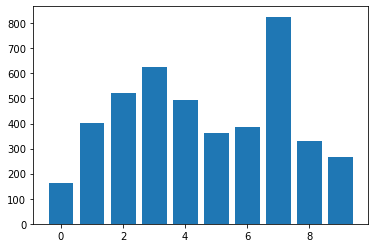

In [75]:
# Visualize the distribution of the high confidence predictions
x, h = np.unique(yt_pred.cpu().numpy()[high_conf_inds], return_counts=True)
plt.bar(x, h)

In [90]:
# Open-set evaluation
bi_y = np.copy(Yt)
bi_y[bi_y >= 10] = 10
bi_pred = yt_pred.cpu().numpy()
bi_pred[low_conf_inds] = 10

In [91]:
print(accuracy_score(bi_y[bi_y < 10],bi_pred[bi_y < 10] ))

0.6494001142639497


In [96]:
print(accuracy_score(bi_y[bi_y >= 10],bi_pred[bi_y >= 10] ))

0.8052543786488741


In [97]:
# Classification report of SEEN categories
print(classification_report(bi_y,bi_pred))

              precision    recall  f1-score   support

           0       0.91      0.41      0.57       360
           1       0.81      0.60      0.69       537
           2       0.99      0.89      0.94       579
           3       0.94      0.75      0.84       783
           4       0.84      0.71      0.77       591
           5       0.97      0.59      0.74       595
           6       0.99      0.74      0.85       516
           7       0.11      0.68      0.19       134
           8       1.00      0.57      0.72       583
           9       0.95      0.44      0.60       573
          10       0.68      0.81      0.74      4796

    accuracy                           0.72     10047
   macro avg       0.84      0.65      0.69     10047
weighted avg       0.80      0.72      0.74     10047



In [102]:
# Binary seen/unseen evaluation
bi_y[bi_y < 10] = 0
bi_y[bi_y >= 10] = 1
bi_pred[bi_pred < 10] = 0
bi_pred[bi_pred >= 10] =1

print(accuracy_score(bi_y,bi_pred))

0.7278789688464218


In [103]:
print(classification_report(bi_y,bi_pred))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      5251
           1       0.68      0.81      0.74      4796

    accuracy                           0.73     10047
   macro avg       0.73      0.73      0.73     10047
weighted avg       0.74      0.73      0.73     10047



In [104]:
cm = confusion_matrix(bi_y, bi_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

[[0.65720815 0.34279185]
 [0.19474562 0.80525438]]


In [105]:
high_conf_xt = Xt[high_conf_inds]
high_conf_yt = Yt[high_conf_inds]
high_conf_yt_pred = yt_pred.cpu().numpy()[high_conf_inds]
high_conf_yt_prob = yt_prob.cpu().numpy()[high_conf_inds]

## (2) Cluster low confident samples into 7 clusters

In [108]:
low_conf_xt = Xt[low_conf_inds]
low_conf_yt = Yt[low_conf_inds]

In [109]:
Knew = 7  
# We directly use the number of unseen classes as the clustering center number. 
# Optimal clustering parameters searching functions is applicable.

In [110]:
kmeans = KMeans(n_clusters=Knew, random_state=0).fit(low_conf_xt)

In [111]:
new7_cents = kmeans.cluster_centers_

In [114]:
for i in range(Knew):
    inds = kmeans.labels_ == i
    lbl, count = np.unique(low_conf_yt[inds], return_counts=True)
    #
    maxCnt = np.max(count)
    maxLb = lbl[np.argmax(count)]
    print(lbl, count)
    print(" Cluter: ", i, " has most class labes: ", maxLb, " with # samples: ", maxCnt, " out of cluster size: ", len(low_conf_yt[inds]))
    print("------------------------------------------------")

[ 0  1  2  3  4  5  6  8  9 10 11 12 13 15 16] [  1  36   1 123  16  74  49   1  32   3   1 608   4   8   6]
 Cluter:  0  has most class labes:  12  with # samples:  608  out of cluster size:  963
------------------------------------------------
[ 2  6 10 11 15 16] [  1   6   1   4 563   4]
 Cluter:  1  has most class labes:  15  with # samples:  563  out of cluster size:  579
------------------------------------------------
[ 0  6  7  8  9 10 11 13 14 15] [ 25   7   4  24  13   5 623   2 110   3]
 Cluter:  2  has most class labes:  11  with # samples:  623  out of cluster size:  816
------------------------------------------------
[ 4  5 16] [  1   3 525]
 Cluter:  3  has most class labes:  16  with # samples:  525  out of cluster size:  529
------------------------------------------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [ 10  60  35  47  35  19  15  22 175 189  60  13  18  16   2   3  35]
 Cluter:  4  has most class labes:  9  with # samples:  189  out of cluster

In [126]:
# by comparing the new cluster centers with ground-truth target class centers
# we can see the relationships/quality of the found new clustering results
ct = torch.Tensor(Prot_Xt).type(FloatTensor)
new_c =torch.Tensor(new7_cents).type(FloatTensor)
new_c_prob_all, new_c_prob, new_c_pred = classify(new_c, ct, dist='cosine', T=1)

In [127]:
new_c_pred

tensor([12, 15, 11, 16,  9, 13, 10], device='cuda:0')

## (3)  Combine all centers and classify to assign pseudo labels/attributes

In [132]:
# Update the centers with the target samples
new10_center = np.zeros((10, 2048))
cnt = np.zeros(10)
for i in range(len(high_conf_xt)):
    xi = high_conf_xt[i]
    yi_pred = high_conf_yt_pred[i].item()
    yi_prob = high_conf_yt_prob[i].item()
    new10_center[yi_pred,:] += xi
    cnt[yi_pred] += yi_prob
for j in range(10):
    if cnt[j] == 0:
        cnt[j] += 1
        new10_center[j,:] = Prot_Xs[j,:]
new10_cents = new10_center / cnt.reshape(-1,1)

In [134]:
# Combine high confidence seen class centers + low confidence samples clustering centers
new_centers = np.concatenate([new10_cents, new7_cents], axis=0)

In [135]:
np.isnan(new_centers).any()

False

In [136]:
# Predict pseudo labels of all target samples
cnew = torch.Tensor(new_centers).type(FloatTensor)
z =torch.Tensor(Xt).type(FloatTensor)
t_prob, yt_prob, yt_pred = classify(z, cnew, dist='cosine', T=1)

<BarContainer object of 17 artists>

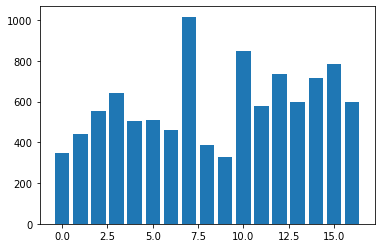

In [137]:
x,h = np.unique(yt_pred.cpu().numpy(), return_counts=True)
plt.bar(x,h)

In [147]:
bi_y = np.copy(Yt)
bi_y[bi_y >= 10] = 10
bi_pred = yt_pred.cpu().numpy()
bi_pred[bi_pred >= 10] = 10

In [148]:
print(accuracy_score(bi_y[bi_y < 10],bi_pred[bi_y < 10] ))

0.7722338602171015


In [149]:
print(accuracy_score(bi_y[bi_y >= 10],bi_pred[bi_y >= 10] ))

0.7829441201000834


In [150]:
print(classification_report(bi_y,bi_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       360
           1       0.89      0.73      0.80       537
           2       0.98      0.93      0.95       579
           3       0.99      0.81      0.89       783
           4       0.97      0.84      0.90       591
           5       0.94      0.80      0.86       595
           6       0.98      0.88      0.93       516
           7       0.08      0.61      0.14       134
           8       0.99      0.65      0.79       583
           9       0.95      0.54      0.69       573
          10       0.77      0.78      0.78      4796

    accuracy                           0.78     10047
   macro avg       0.85      0.76      0.78     10047
weighted avg       0.86      0.78      0.81     10047



In [151]:
bi_y[bi_y < 10] = 0
bi_y[bi_y >= 10] = 1
bi_pred[bi_pred < 10] = 0
bi_pred[bi_pred >= 10] =1

print(accuracy_score(bi_y,bi_pred))

0.7866029660595203


In [152]:
print(classification_report(bi_y,bi_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      5251
           1       0.77      0.78      0.78      4796

    accuracy                           0.79     10047
   macro avg       0.79      0.79      0.79     10047
weighted avg       0.79      0.79      0.79     10047



In [153]:
cm = confusion_matrix(bi_y, bi_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

[[0.78994477 0.21005523]
 [0.21705588 0.78294412]]


## (4) Save the class/cluster centers & Pseudo labels

In [56]:
center_name = './'+src+'2'+tgt+'_sample_xt_clu_cents17.csv'
pd.DataFrame(new_centers).to_csv(center_name, index=False)
pseudo_name = './'+src+'2'+tgt+'_sample_pseudo.csv'
pd.DataFrame(yt_pred.cpu().numpy()).to_csv(pseudo_name, index=None)